In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
input_data = pd.read_csv('./data/만족도모델_입력데이터2.csv', encoding='cp949')

input_data

,기업명,납기준수율,평균 납기지체일수,하자처리 건수,품질 만족도,가격 만족도,서비스 만족도,사후 만족도,납품품목비율,하자처리 기간,부정당업자 제재기간,거래정지 기간
0,우수1,95,1,1,6,5,6,5,92,3,1,5
1,우수2,85,5,2,5,5,4,4,87,6,15,30
2,보통,65,10,5,3,4,3,3,74,9,40,45
3,미흡1,45,17,7,2,3,2,2,50,12,90,80
4,미흡2,40,20,8,1,1,0,1,43,15,120,101


In [3]:
# 평가항목 정보
dline_rate = {'항목' : '납기준수율', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : False, '배점' : 13}
dline_delay = {'항목' : '평균 납기지체일수', '최솟값' : 0, '최댓값' : 30, '망대 여부' : False, '퍼지 여부' : False, '배점' : 12}
flaw = {'항목' : '하자처리 건수', '최솟값' : 0, '최댓값' : 8, '망대 여부' : False, '퍼지 여부' : False, '배점' : 9}
quality = {'항목' : '품질 만족도', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : True, '배점' : 12}
price = {'항목' : '가격 만족도', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
service = {'항목' : '서비스 만족도', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
post = {'항목' : '사후 만족도', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
item_rate = {'항목' : '납품품목비율', '최솟값' : 0, '최댓값' : 100, '망대 여부' : True, '퍼지 여부' : False, '배점' : 8}
as_period = {'항목' : '하자처리기간', '최솟값' : 3, '최댓값' : 24, '망대 여부' : False, '퍼지 여부' : False, '배점' : 8}
fraud_penalty  = {'항목' : '부정당업자 제재기간', '최솟값' : 0, '최댓값' : 270, '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}
trade_penalty  = {'항목' : '거래정지 기간', '최솟값' : 0, '최댓값' : 270, '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}

pd.DataFrame([dline_rate, dline_delay, flaw, quality, price, service, post, item_rate, as_period, fraud_penalty, trade_penalty])

,항목,최솟값,최댓값,망대 여부,퍼지 여부,배점
0,납기준수율,0,100,True,False,13
1,평균 납기지체일수,0,30,False,False,12
2,하자처리 건수,0,8,False,False,9
3,품질 만족도,0,100,True,True,12
4,가격 만족도,0,100,True,True,6
5,서비스 만족도,0,100,True,True,6
6,사후 만족도,0,100,True,True,6
7,납품품목비율,0,100,True,False,8
8,하자처리기간,3,24,False,False,8
9,부정당업자 제재기간,0,270,False,False,10


In [4]:
# 사다리꼴 퍼지수 구간
pts_list = []
a = 0; b = 12.5
for _ in range(7):
    pts_list.append((a, b))
    a += 12.5 + 2.08
    b += 2.08 + 12.5
    
pts_list

[(0, 12.5),
 (14.58, 27.08),
 (29.16, 41.66),
 (43.74, 56.239999999999995),
 (58.32, 70.82),
 (72.9, 85.39999999999999),
 (87.48, 99.97999999999999)]

In [5]:
class model():
    def __init__(self):
        # 평가항목별 정보
        self.dline_rate = {'항목' : '납기준수율', '최솟값' : 0, '최댓값' : 100,
                           '망대 여부' : True, '퍼지 여부' : False, '배점' : 13}
        self.dline_delay = {'항목' : '평균 납기지체일수', '최솟값' : 0, '최댓값' : 30,
                            '망대 여부' : False, '퍼지 여부' : False, '배점' : 12}
        self.flaw = {'항목' : '하자처리 건수', '최솟값' : 0, '최댓값' : 8,
                     '망대 여부' : False, '퍼지 여부' : False, '배점' : 9}
        self.quality = {'항목' : '품질 만족도', '최솟값' : 0, '최댓값' : 100,
                        '망대 여부' : True, '퍼지 여부' : True, '배점' : 12}
        self.price = {'항목' : '가격 만족도', '최솟값' : 0, '최댓값' : 100,
                      '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.service = {'항목' : '서비스 만족도', '최솟값' : 0, '최댓값' : 100,
                        '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.post = {'항목' : '사후 만족도', '최솟값' : 0, '최댓값' : 100,
                     '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.item_rate = {'항목' : '납품품목비율', '최솟값' : 0, '최댓값' : 100,
                          '망대 여부' : True, '퍼지 여부' : False, '배점' : 8}
        self.as_period = {'항목' : '하자처리기간', '최솟값' : 3, '최댓값' : 24,
                          '망대 여부' : False, '퍼지 여부' : False, '배점' : 8}
        self.fraud_penalty  = {'항목' : '부정당업자 제재기간', '최솟값' : 0, '최댓값' : 270,
                               '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}
        self.trade_penalty  = {'항목' : '거래정지 기간', '최솟값' : 0, '최댓값' : 270,
                               '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}

        # 평가항목 리스트
        self.list = {'납기준수율' : self.dline_rate, '평균 납기지체일수' : self.dline_delay, '하자처리 건수' : self.flaw,
                     '품질 만족도' : self.quality, '가격 만족도' : self.price, '서비스 만족도' : self.service,
                     '사후 만족도' : self.post, '납품품목비율' : self.item_rate, '하자처리 기간' : self.as_period,
                     '부정당업자 제재기간' : self.fraud_penalty, '거래정지 기간' : self.trade_penalty}
        
        # 사다리꼴 퍼지수 피크 구간
        self.pts_list = [(0, 12.5), (14.58, 27.08), (29.16, 41.66), (43.74, 56.24), (58.32, 70.82), (72.9, 85.4), (87.48, 100)]
    
    # 구간 연산 - 뺄셈 함수: intv1 - intv2
    def intv_sub(self, intv1, intv2):
        min_ = intv1[0] - intv2[1]
        max_ = intv1[1] - intv2[0]
        return min_, max_
    
    # 만족도 계산
    def get_fuzzy_score(self, y_i, y_min, y_max, isMangdae, isFuzzy):
        if isMangdae:    # 망대 특성인 경우
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연산를 위해 nunmpy array로 변환
                y_min = np.array([y_min, y_min])
                y_max = np.array([y_max, y_max])
                y_i = np.array(y_i)
                if np.mean(y_i) < np.mean(y_min):
                    score = (0, 0)
                elif np.mean(y_i) > np.mean(y_max):
                    score = (1, 1)
                else:
                    bunja = self.intv_sub(y_i, y_min)
                    bunmo = self.intv_sub(y_max, y_min)
                    cases = [a/b for a in bunja for b in bunmo]       # 분자/분모의 구간 연산
                    score = (min(cases), max(cases))

                return score

            else:       # Crisp 데이터인 경우
                if y_i <= y_min:
                    score = 0
                elif y_i >= y_max:
                    score = 1
                else:
                    score = (y_i - y_min) / (y_max - y_min)

                return (score, score)


        else:    # 망소 특성인 경우 -> 1에서 뺀 값을 반환
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연상를 위해 nunmpy array로 변환
                y_min = np.array([y_min, y_min])
                y_max = np.array([y_max, y_max])
                y_i = np.array(y_i)

                if np.mean(y_i) < np.mean(y_min):
                    score = (1, 1)
                elif np.mean(y_i) > np.mean(y_max):
                    score = (0, 0)
                else:
                    bunja = self.intv_sub(y_i, y_min)
                    bunmo = self.intv_sub(y_max, y_min)
                    cases = [a/b for a in bunja for b in bunmo]        # 분자/분모의 구간 연산
                    score = (1-max(cases), 1-min(cases))

                return score

            else:       # Crisp 데이터인 경우
                if y_i <= y_min:
                    score = 0
                elif y_i >= y_max:
                    score = 1
                else:
                    score = (y_i - y_min) / (y_max - y_min)

                return (1-score, 1-score)
    
    def get_score(self, data):
        total_score = np.array([0., 0.])
        for key, value in dict(data[1:]).items():   # key : 평가항목명, value : 해당 항목 관측값
            info = self.list[key]                    # 해당 항목 정보
            y_i = value
            y_min = info['최솟값']; y_max = info['최댓값']
            isMangdae = info['망대 여부']; isFuzzy = info['퍼지 여부']
            allot = info['배점']
            if isFuzzy:
                y_i = self.pts_list[y_i]
            
            total_score += np.array(self.get_fuzzy_score(y_i, y_min, y_max, isMangdae, isFuzzy)) * allot
            
        return total_score / 100

In [6]:
def plot_trape(score, score_with_spread, col):
    plt.plot((score_with_spread[0], score[0]), (0, height), color=col)
    plt.plot((score[0], score[1]), (height, height), color=col)
    plt.plot((score[1], score_with_spread[1]), (height, 0), color=col)

In [7]:
sat_model = model()

기업명 : 우수1,   만족도 : (0.915, 0.952),   만족도(spread) : (0.852, 1.000)
기업명 : 우수2,   만족도 : (0.801, 0.838),   만족도(spread) : (0.738, 0.901)
기업명 : 보통 ,   만족도 : (0.623, 0.661),   만족도(spread) : (0.561, 0.723)
기업명 : 미흡1,   만족도 : (0.441, 0.478),   만족도(spread) : (0.378, 0.541)
기업명 : 미흡2,   만족도 : (0.314, 0.351),   만족도(spread) : (0.251, 0.414)


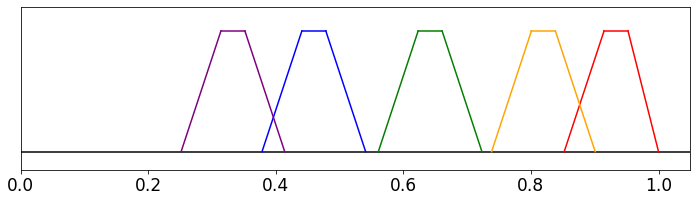

In [12]:
# 결과 확인
height = 1
cols = ['red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 3))
plt.plot((-0.5, 2.5), (0, 0), 'black')
plt.xlim(0, 1.05)
plt.ylim(-0.15, height+0.2)
plt.xticks(size=17)
plt.yticks([])


for i in range(len(input_data)):
    data = input_data.iloc[i]
    company_name = data[0]
    score = sat_model.get_score(data)
    score_with_spread = np.clip(score + np.array([-0.0625, 0.0625]), 0, 1)
    print('기업명 : {:3s},   만족도 : ({:.3f}, {:.3f}),   만족도(spread) : ({:.3f}, {:.3f})'.format(
           company_name, score[0], score[1], score_with_spread[0], score_with_spread[1]))
    
    plot_trape(score, score_with_spread, cols[i])
    
plt.show()